In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
# import starspot as ss
import pandas as pd

In [55]:
s = lk.search_lightcurve('KIC 892376')
s
# if np.where(s.table['mission']=='Kepler Quarter 04')[0].size == 0:
#     print('hehe')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 01,2009,Kepler,1800,kplr000892376,0.0
1,Kepler Quarter 02,2009,Kepler,1800,kplr000892376,0.0
2,Kepler Quarter 03,2009,Kepler,1800,kplr000892376,0.0
3,Kepler Quarter 04,2010,Kepler,1800,kplr000892376,0.0
4,Kepler Quarter 05,2010,Kepler,1800,kplr000892376,0.0
5,Kepler Quarter 06,2010,Kepler,1800,kplr000892376,0.0
6,Kepler Quarter 07,2010,Kepler,1800,kplr000892376,0.0
7,Kepler Quarter 08,2011,Kepler,1800,kplr000892376,0.0
8,Kepler Quarter 09,2011,Kepler,1800,kplr000892376,0.0


In [2]:
def tessify(lc, sector=14, start_modifier=0):
    
    # get tess orbit timing
    tess_orbits = pd.read_csv('https://tess.mit.edu/wp-content/uploads/orbit_times_20201013_1338.csv',skiprows=5)
    sectors = tess_orbits['Sector']
    starts = tess_orbits['Start TJD']
    ends = tess_orbits['End TJD']
    
    start1 = starts[sectors==sector].iloc[0]
    end1 = ends[sectors==sector].iloc[0]
    start2 = starts[sectors==sector].iloc[1]
    end2 = ends[sectors==sector].iloc[1]
    span1 = end1-start1
    gap = start2-end1
    span2 = end2-start2
    
    keep = np.zeros(lc.time.value.shape, dtype=bool)

    # get cadence numbers for stop and start points
    try:
        newstart1 = 0 + start_modifier
        newend1 = np.where(np.isclose(lc.time.value,lc.time.value[0] + span1))[0][0] + start_modifier
        newstart2 = np.where(np.isclose(lc.time.value,lc.time.value[newend1] + gap))[0][0] + start_modifier
        newend2 = np.where(np.isclose(lc.time.value,lc.time.value[newstart2] + span2))[0][0] + start_modifier
    except IndexError:
        raise IndexError('Data selected is out of range. Try using a lower start_modifier')
    
    keep[newstart1:newend1+1] = True
    keep[newstart2:newend2+1] = True
    
    lc_new = lk.LightCurve()
    lc_new.time = lc.time.value[keep==True]
    lc_new.flux = lc.flux.value[keep==True]
    lc_new.flux_err = lc.flux_err.value[keep==True]
    
    return lc_new

In [3]:
lc = lk.search_lightcurve('KIC 4936891', quarter=9).download().remove_outliers()
# lc = lk.search_lightcurve('KIC 4937356', quarter=9).download().remove_outliers()
# lc = lk.search_lightcurve('KIC 7461601', quarter=9).download().remove_outliers() #example nonrotator

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

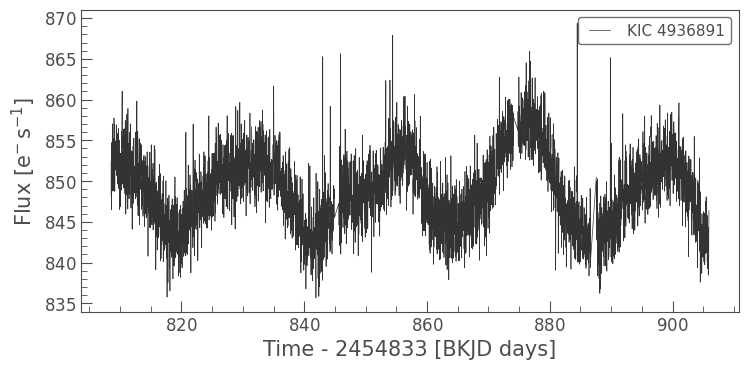

In [4]:
lc.plot()

In [5]:
lc_new = tessify(lc)#, start_modifier=90)

<AxesSubplot:xlabel='Time', ylabel='Flux'>

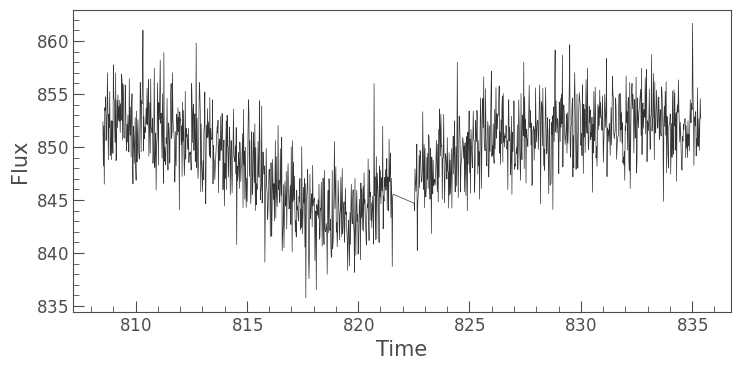

In [6]:
lc_new.plot()

## Testing starspot on Kepler q9

In [20]:
rotate = ss.RotationModel(lc.time.value, lc.flux.value, lc.flux_err.value)

In [21]:
ls_period = rotate.ls_rotation()
ls_period

14.19827233694541

In [22]:
kep_cadence = 1/24/2 # 30min cadence
acf_period = rotate.acf_rotation(kep_cadence)
acf_period

1.0416666666666665

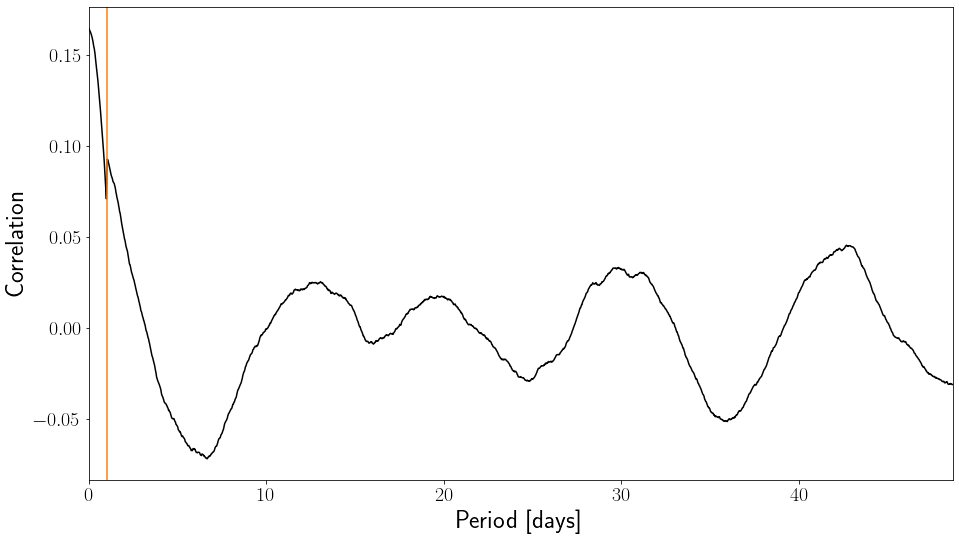

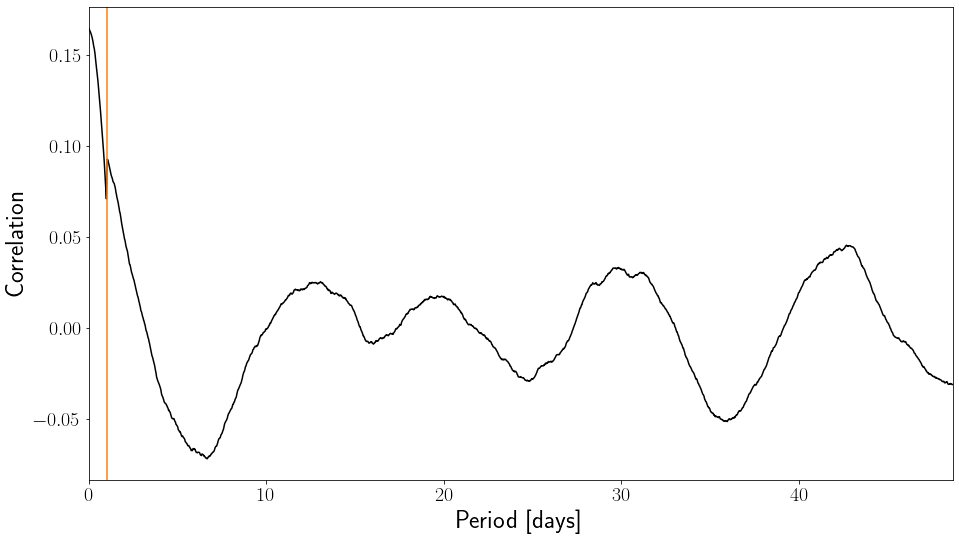

In [23]:
rotate.acf_plot()

## Testing starspot on TESS-ish data

In [24]:
rotate = ss.RotationModel(lc_new.time.value, lc_new.flux.value, lc_new.flux_err.value)

In [25]:
ls_period = rotate.ls_rotation()
ls_period

14.600525624178713

In [85]:
10**1.35

22.3872113856834

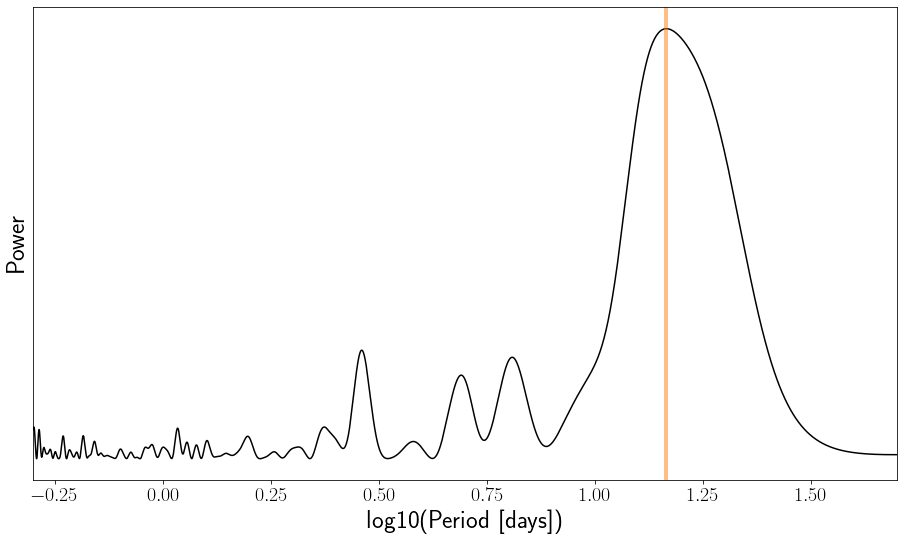

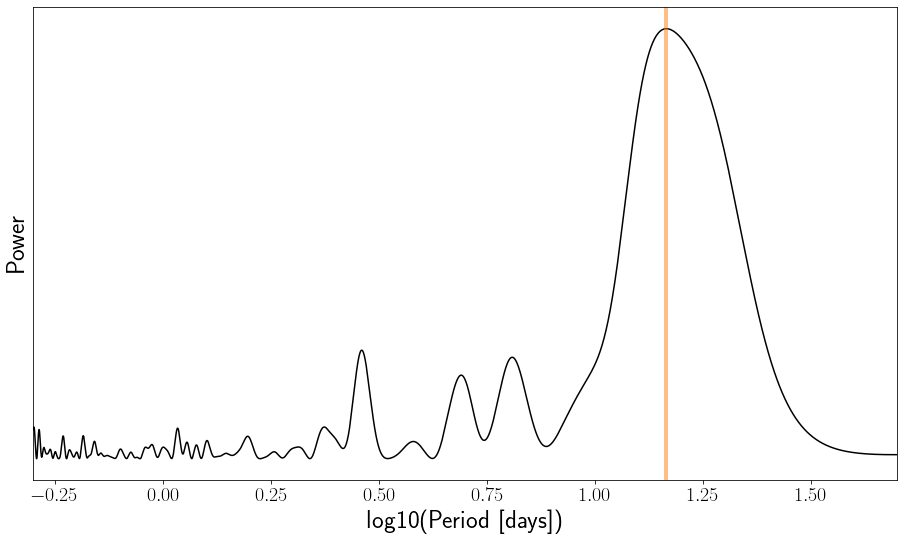

In [26]:
rotate.ls_plot()

In [27]:
tess_cadence = 1/24/2 # 30min cadence
acf_period = rotate.acf_rotation(tess_cadence)
acf_period

0.041666666666666664

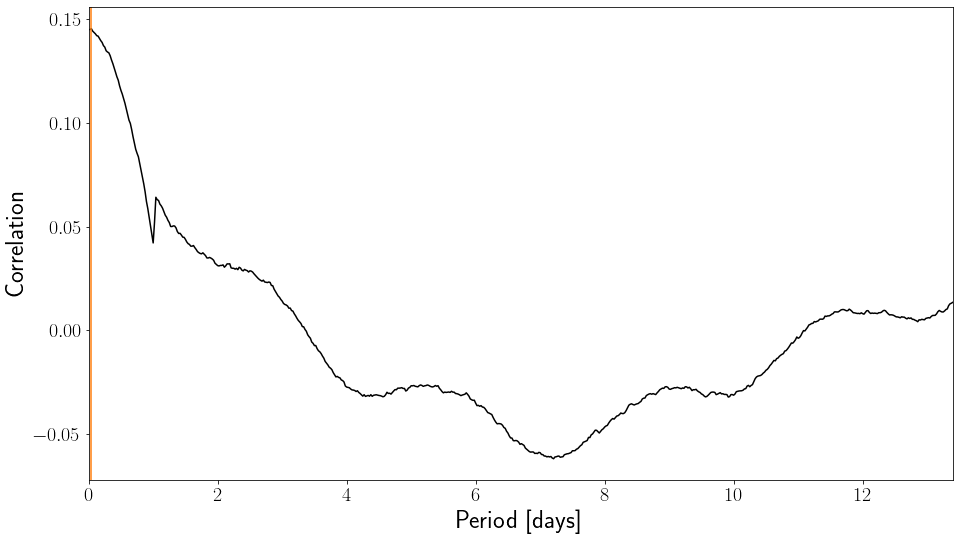

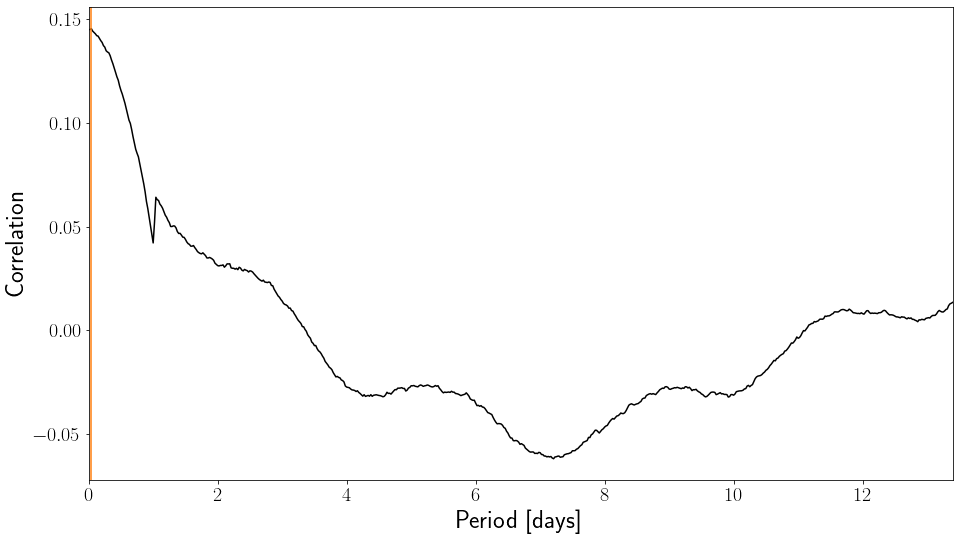

In [28]:
rotate.acf_plot()